In [2]:
import json, gzip
import numpy as np
import xgboost as xgb
import pandas as pd
from pathlib import Path
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import GroupShuffleSplit
import optuna
from sklearn.model_selection import StratifiedGroupKFold
import joblib
def parse_json_line(obj):
    (tid, tdata), = obj.items()
    (pos_key, contexts), = tdata.items()
    pos = int(pos_key) if isinstance(pos_key, str) else pos_key
    (ctx7, reads), = contexts.items()
    arr = np.asarray(reads, dtype=float)
    return tid, pos, ctx7, arr

BASE_IDX = {"A":0, "C":1, "G":2, "T":3}
def onehot28(seq7: str) -> np.ndarray:
    out = np.zeros((7,4), dtype=np.int8)
    s = (seq7 or "").upper()
    for i in range(min(7, len(s))):
        j = BASE_IDX.get(s[i], -1)
        if j >= 0:
            out[i, j] = 1
    return out.ravel()

def aggregate_9(arr: np.ndarray) -> np.ndarray:
    if arr.size == 0:
        return np.zeros(45, dtype=np.float32)
    mean = arr.mean(axis=0)
    std  = arr.std(axis=0, ddof=0)
    mn   = arr.min(axis=0)
    mx   = arr.max(axis=0)
    med  = np.median(arr, axis=0)
    return np.concatenate([mean, std, mn, mx, med]).astype(np.float32, copy=False)

NUM_COLS = [
    "dwell_m1","sd_m1","mean_m1",
    "dwell_0","sd_0","mean_0",
    "dwell_p1","sd_p1","mean_p1",
]
FEATURE_NAMES = (
    [f"mean_{c}"   for c in NUM_COLS] +
    [f"std_{c}"    for c in NUM_COLS] +
    [f"min_{c}"    for c in NUM_COLS] +
    [f"max_{c}"    for c in NUM_COLS] +
    [f"median_{c}" for c in NUM_COLS] +
    [f"ctx_{i}"    for i in range(28)]
)


def build_dataset_from_json_objects(json_objects, label_dict, transcript_to_gene):
    """
    json_objects: iterable of parsed per-line dicts
    label_dict: {(transcript_id, position): 0/1}
    Returns X (N,73), y (N,), plus ids for later mapping.
    """
    X_rows, y_rows, ids = [], [], []
    for obj in json_objects:
        tid, pos, ctx7, arr = parse_json_line(obj)
        feats45 = aggregate_9(arr)
        ctx28   = onehot28(ctx7)
        X_rows.append(np.concatenate([feats45, ctx28]))
        y_rows.append(label_dict.get((tid, int(pos)), None))
        gene = transcript_to_gene.get((tid, None))
        ids.append((gene, tid, int(pos)))
    X = np.asarray(X_rows, dtype=np.float32)
    y = np.asarray(y_rows)
    return X, y, ids

def make_data_splits(X, y, ids, test_size=0.3, val_size=0.5, random_state=4262):
    mask = ~pd.isna(y)
    X_tr = X[mask]
    y_tr = y[mask].astype(int)

    groups = np.array([
        str(gene) if gene is not None else tid
        for gene, tid, pos in ids
    ])[mask]

    gss = GroupShuffleSplit(test_size=test_size, random_state=random_state)
    train_idx, temp_idx = next(gss.split(X_tr, y_tr, groups=groups))

    gss2 = GroupShuffleSplit(test_size=val_size, random_state=random_state)
    val_idx, test_idx = next(gss2.split(X_tr[temp_idx], y_tr[temp_idx], groups=groups[temp_idx]))

    train_genes = set(groups[train_idx])
    val_genes   = set(groups[temp_idx][val_idx])
    test_genes  = set(groups[temp_idx][test_idx])
    assert len(train_genes & val_genes) == 0, "Gene overlap between train and val!"
    assert len(train_genes & test_genes) == 0, "Gene overlap between train and test!"
    assert len(val_genes & test_genes) == 0, "Gene overlap between val and test!"
    print(f"Split complete: {len(train_genes)} train genes, {len(val_genes)} val genes, {len(test_genes)} test genes")

    return {
        "X_train": X[train_idx], "y_train": y[train_idx],
        "X_val": X[temp_idx][val_idx], "y_val": y[temp_idx][val_idx],
        "X_test": X[temp_idx][test_idx], "y_test": y[temp_idx][test_idx],
        "ids_train": [ids[i] for i in train_idx],
        "ids_val": [ids[i] for i in temp_idx[val_idx]],
        "ids_test": [ids[i] for i in temp_idx[test_idx]]
    }
    

def iter_json_lines(path: str):
    """Stream NDJSON from .json or .json.gz"""
    p = Path(path)
    if p.suffix == ".gz":
        with gzip.open(p, "rt", encoding="utf-8", errors="replace") as f:
            for line in f:
                s = line.strip()
                if s:
                    yield json.loads(s)
    else:
        with open(p, "r", encoding="utf-8") as f:
            for line in f:
                s = line.strip()
                if s:
                    yield json.loads(s)
                    
df_labels = pd.read_csv("data_task1/data.info.labelled.csv")
label_dict = { (r.transcript_id, int(r.transcript_position)): int(r.label) for r in df_labels.itertuples(index=False)}
transcript_to_gene = dict(zip(df_labels['transcript_id'], df_labels['gene_id']))

train_json_iter = iter_json_lines("data_task1/dataset0.json")
X, y, ids = build_dataset_from_json_objects(train_json_iter, label_dict, transcript_to_gene)
data = make_data_splits(X, y, ids)

X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']

y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']

ids_train = data['ids_train']
ids_val = data['ids_val']
ids_test = data['ids_test']

Split complete: 3733 train genes, 800 val genes, 800 test genes


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=5000, solver='lbfgs', class_weight='balanced')
)
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=5000))])

In [4]:
from sklearn.metrics import roc_auc_score

y_pred = model.predict_proba(X_val)[:, 1]
print("AUC:", roc_auc_score(y_val, y_pred))

y_pred_proba = model.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_auc_score, average_precision_score

roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC:  {pr_auc:.4f}")

AUC: 0.8860637427329455
ROC AUC: 0.9051
PR AUC:  0.4417


In [5]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=200,      # number of trees
    max_depth=None,        # let trees expand fully
    random_state=42,       # reproducibility
    class_weight='balanced' # good for imbalanced data
)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

Validation ROC AUC: 0.910
Validation PR AUC: 0.431
Test ROC AUC: 0.918
Test PR AUC: 0.477


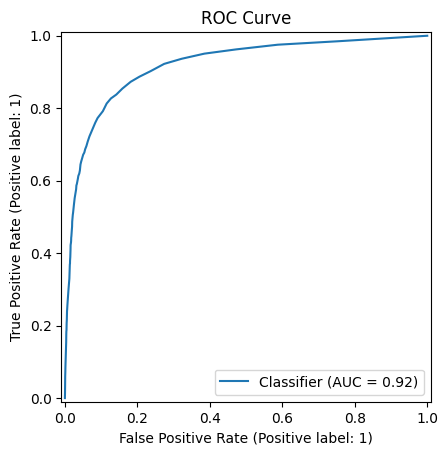

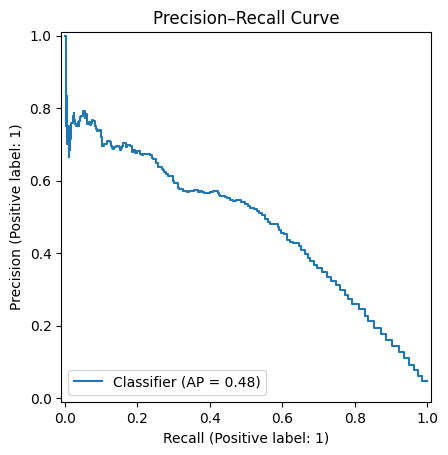

In [6]:
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

# Predict probabilities for ROC and PR curve metrics
y_val_pred_proba = rf.predict_proba(X_val)[:, 1]
y_test_pred_proba = rf.predict_proba(X_test)[:, 1]

# ROC AUC
roc_auc_val = roc_auc_score(y_val, y_val_pred_proba)
roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)

# PR AUC (Average Precision)
pr_auc_val = average_precision_score(y_val, y_val_pred_proba)
pr_auc_test = average_precision_score(y_test, y_test_pred_proba)

print(f"Validation ROC AUC: {roc_auc_val:.3f}")
print(f"Validation PR AUC: {pr_auc_val:.3f}")
print(f"Test ROC AUC: {roc_auc_test:.3f}")
print(f"Test PR AUC: {pr_auc_test:.3f}")

RocCurveDisplay.from_predictions(y_test, y_test_pred_proba)
plt.title("ROC Curve")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_test_pred_proba)
plt.title("Precision–Recall Curve")
plt.show()